In [705]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt

In [706]:
N_CONCEPTS = 2
N_STUDENTS = 10
N_ATTEMPTS = 3
N_QUESTIONS = 5

# Algorithm parameters
INIT = 3
MAX_ITER = 100

### ALS Tensor Factorization

In [722]:
def als_tensor_factorization(student_performance, n_concepts=2, init=3, max_iter=100):
    
    # Get values from student performance tensor shape
    n_questions, n_students, n_attempts = student_performance.shape
    
    student_knowledge = np.zeros((n_concepts, n_students, n_attempts))

    error_run = []
    error_total_run = []
    student_performance_pred_run = []
    
    # Several starts
    for run in range(init):
        error = []
        student_performance_pred_list = []
    #     q_matrix = np.random.rand(N_QUESTIONS, N_CONCEPTS)

        for attempt in range(N_ATTEMPTS):
            student_knowledge[:, :, attempt] = np.random.rand(n_concepts, n_students)

        # Phase 1: prediction
        student_performance_pred = np.zeros((n_questions, n_students, n_attempts))
        for i in range(max_iter):

            # Update Q: Q = YT'(TT')^(-1) = YT^(-1)
            # (TT')^(-1)
            student_knowledge_transposed = np.zeros((n_concepts, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                student_knowledge_transposed[:, :, attempt] = np.dot(student_knowledge[:, :, attempt], 
                                                                     student_knowledge[:, :, attempt].T)
            student_knowledge_transposed = student_knowledge_transposed.sum(axis=2)
            student_knowledge_transposed_inv = np.linalg.pinv(student_knowledge_transposed)
            
            # YT'
            YT = np.zeros((n_questions, n_concepts, n_attempts))
            for attempt in range(n_attempts):
                YT[:, :, attempt] = np.dot(student_performance[:, :, attempt],
                                                      student_knowledge[:, :, attempt].T)
            YT = YT.sum(axis=2) 
            
            ## TODO: add regularization parameters (lambda)
            # Q = YT'(TT')^(-1)
            q_matrix = np.dot(YT, student_knowledge_transposed_inv)
            # Impose non-negativity constraint
            q_matrix[q_matrix < 0] = 0
            # Normalize rows to sum one
            row_sums = q_matrix.sum(axis=1, keepdims=True)
            q_matrix = q_matrix / row_sums
            
            # Update T: T = (Q'Q)^(-1)Q'Y = Q^(-1)Y
            # (Q'Q)^(-1)
            q_matrix_transpose_inv = np.linalg.pinv(np.dot(q_matrix.T, q_matrix))
            
            # Q'Y
            QY = np.zeros((n_concepts, n_students, n_attempts))
            for attempt in range(n_attempts):
                QY[:, :, attempt] = np.dot(q_matrix.T, student_performance[:, :, attempt])
                
            # T = (Q'Q)^(-1)Q'Y    
            for attempt in range(n_attempts):
                student_knowledge[:, :, attempt] = np.dot(q_matrix_transpose_inv, QY[:, :, attempt])
                
            # Y = QT
            for attempt in range(n_attempts):
                student_performance_pred[:, :, attempt] = np.dot(q_matrix, student_knowledge[:, :, attempt])
                
            
            diff = np.zeros((n_questions, n_students, n_attempts))
            for attempt in range(n_attempts):
                diff[:, :, attempt] = student_performance[:, :, attempt] - student_performance_pred[:, :, attempt]
            # Frobenius norm (norm-2)
            error.append(np.sqrt(np.sum(np.power(diff, 2))))
            
            student_performance_pred_iter = student_performance_pred.copy()
            student_performance_pred_list.append(student_performance_pred_iter)
        student_performance_pred_run.append(student_performance_pred_list)
        error_run.append(error)
        error_total_run.append(error[-1])
                
            
    return np.asarray(student_performance_pred_run), np.asarray(error_run), error_total_run

### Simulation 1 - Student Performance is the exact multiplication of  Q Matrix and Student Knowledge

In [708]:
def generate_sample(noise=0):
    DENSITY = 0.8

    # Create sparse q_matrix and normalize it to sum 1
    q_matrix = sparse.rand(N_QUESTIONS, N_CONCEPTS, DENSITY).todense()
    row_sums = q_matrix.sum(axis=1)
    while not(np.all(row_sums)):
        q_matrix = sparse.rand(N_QUESTIONS, N_CONCEPTS, DENSITY).todense()
        row_sums = q_matrix.sum(axis=1)
    q_matrix = q_matrix / row_sums

    student_knowledge = np.zeros((N_CONCEPTS, N_STUDENTS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_knowledge[:, :, attempt] = sparse.rand(N_CONCEPTS, N_STUDENTS, DENSITY).todense()

    student_performance = np.zeros((N_QUESTIONS, N_STUDENTS, N_ATTEMPTS))
    for attempt in range(N_ATTEMPTS):
        student_performance[:, :, attempt] = np.dot(q_matrix, student_knowledge[:, :, attempt])
        
    if noise:
        noise = np.random.normal(0, noise, (N_QUESTIONS, N_STUDENTS, N_ATTEMPTS))
        student_performance = student_performance + noise
        
    return student_performance

In [709]:
student_performance = generate_sample()

In [710]:
student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
    student_performance, n_concepts=2, init=1, max_iter=10)

In [711]:
error_run

array([[8.00304491e-03, 3.72369373e-15, 5.10288706e-15, 2.50820126e-15,
        4.99354133e-15, 3.78308481e-15, 2.11334646e-15, 4.62617256e-15,
        3.33463801e-15, 4.51419710e-15]])

### Simulation 2 - Student Performance is the multiplication of Q Matrix and Student Knowledge plus noise

In [712]:
student_performance = generate_sample(0.5)

In [713]:
student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=50)

In [714]:
error_run

array([[4.75827561, 4.40077378, 4.20804919, 4.15858542, 4.14618965,
        4.14220546, 4.14060011, 4.13305479, 4.12843784, 4.12642167,
        4.1254945 , 4.12505682, 4.12484696, 4.12316266, 4.12214109,
        4.12182187, 4.12178603, 4.12185565, 4.12195543, 4.12205471,
        4.12214233, 4.12221549, 4.12227477, 4.122322  , 4.1223592 ,
        4.12238832, 4.12241099, 4.12242859, 4.12244223, 4.12245278,
        4.12246093, 4.12246722, 4.12247207, 4.12247582, 4.1224787 ,
        4.12248093, 4.12248264, 4.12248396, 4.12248498, 4.12248577,
        4.12248637, 4.12248684, 4.12248719, 4.12248747, 4.12248768,
        4.12248785, 4.12248797, 4.12248807, 4.12248815, 4.1224882 ],
       [4.10162914, 4.11504662, 4.12895235, 4.1332719 , 4.13397264,
        4.12787495, 4.12526642, 4.12404529, 4.1234295 , 4.12309571,
        4.12290131, 4.12278025, 4.12270041, 4.12264531, 4.122606  ,
        4.12257729, 4.12255597, 4.12253996, 4.12252785, 4.12251864,
        4.12251162, 4.12250624, 4.12250211, 4.1

### Simulation 3 - Student Performance contains only zeros and ones

In [715]:
student_performance[student_performance > 0.5] = 1
student_performance[student_performance < 0.5] = 0

In [716]:
student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
    student_performance, n_concepts=2, init=3, max_iter=100)

In [717]:
error_run = np.asarray(error_run)

In [718]:
best_run = np.unravel_index(error_run.argmin(), error_run.shape)
best_student_performance_pred = student_performance_pred_run[best_run]

In [719]:
best_student_performance_pred[best_student_performance_pred > 0.5] = 1
best_student_performance_pred[best_student_performance_pred < 0.5] = 0

In [720]:
acc = 100*(np.logical_not(np.logical_xor(
    student_performance, best_student_performance_pred)).sum())/(
    student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
print("Accuracy: %.2f%%" % acc)

Accuracy: 86.00%


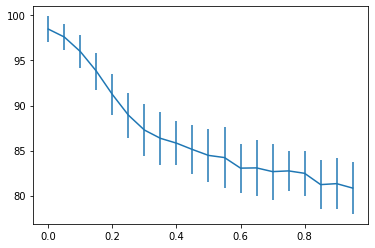

CPU times: user 1min 16s, sys: 7.85 ms, total: 1min 16s
Wall time: 1min 16s


In [676]:
%%time
accs = []
accs_std = []
for noise in np.arange(0, 1, 0.05):
    accs_run = []
    for run in range(50):
        # Generate sample and approximate values to 0 and 1
        student_performance = generate_sample(noise)
        student_performance[student_performance > 0.5] = 1
        student_performance[student_performance < 0.5] = 0

        # Run tensor factorization
        student_performance_pred_run, error_run, error_total_run = als_tensor_factorization(
            student_performance, n_concepts=2, init=3, max_iter=50)

        # Get best run results
        best_run = np.unravel_index(error_run.argmin(), error_run.shape)
        best_student_performance_pred = student_performance_pred_run[best_run]
        best_student_performance_pred[best_student_performance_pred > 0.5] = 1
        best_student_performance_pred[best_student_performance_pred < 0.5] = 0

        # Calculate accuracy
        acc = 100*(np.logical_not(np.logical_xor(
            student_performance, best_student_performance_pred)).sum())/(
            student_performance.shape[0]*student_performance.shape[1]*student_performance.shape[2])
        accs_run.append(acc)
    accs.append(np.asarray(accs_run).mean())
    accs_std.append(np.asarray(accs_run).std())
    
plt.errorbar(np.arange(0, 1, 0.05), accs, yerr=accs_std)
plt.show()

In [485]:
diff = np.zeros((N_QUESTIONS, N_STUDENTS, N_ATTEMPTS))
for attempt in range(N_ATTEMPTS):
    diff[:, :, attempt] = student_performance[:, :, attempt] - best_student_performance_pred[:, :, attempt]

In [486]:
np.sqrt(np.sum(np.power(diff, 2)))

4.898979485566356